In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# for training our model
train_values = pd.read_csv('train_values.csv', index_col='patient_id')
train_labels = pd.read_csv('train_labels.csv', index_col='patient_id')

In [3]:
train_values.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [4]:
train_values.dtypes

slope_of_peak_exercise_st_segment         int64
thal                                     object
resting_blood_pressure                    int64
chest_pain_type                           int64
num_major_vessels                         int64
fasting_blood_sugar_gt_120_mg_per_dl      int64
resting_ekg_results                       int64
serum_cholesterol_mg_per_dl               int64
oldpeak_eq_st_depression                float64
sex                                       int64
age                                       int64
max_heart_rate_achieved                   int64
exercise_induced_angina                   int64
dtype: object

In [5]:
train_labels.head()

,heart_disease_present
patient_id,
0z64un,0
ryoo3j,0
yt1s1x,1
l2xjde,1
oyt4ek,0


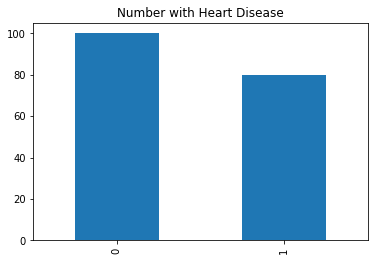

In [6]:
train_labels.heart_disease_present.value_counts().plot.bar(title='Number with Heart Disease')

In [7]:
selected_features = ['age', 
                     'sex', 
                     'max_heart_rate_achieved', 
                     'resting_blood_pressure']
train_values_subset = train_values[selected_features]

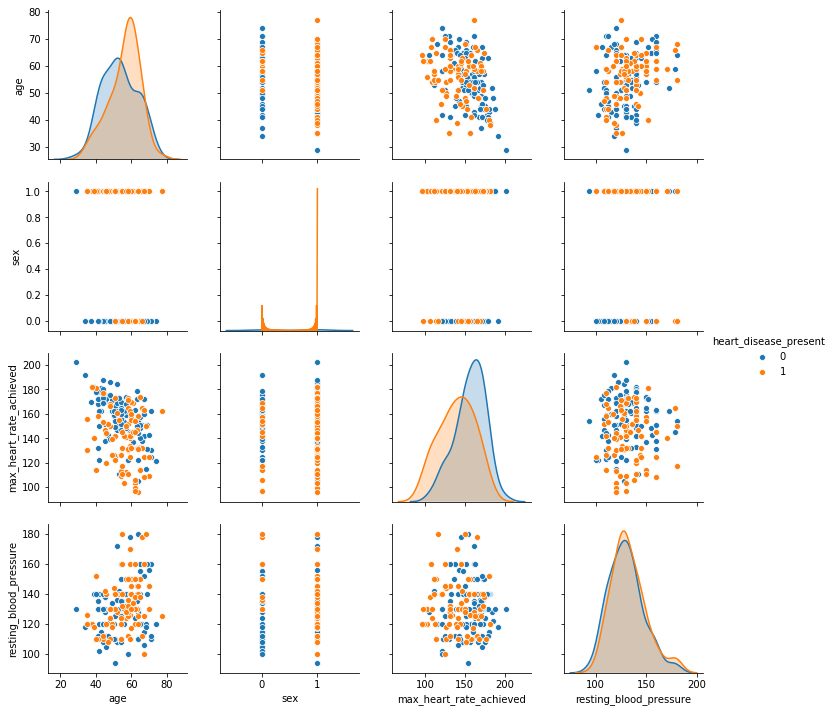

In [8]:
sns.pairplot(train_values.join(train_labels), 
             hue='heart_disease_present', 
             vars=selected_features)

In [9]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.linear_model import LogisticRegression

# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing parameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [10]:
pipe = Pipeline(steps=[('scale', StandardScaler()), 
                       ('logistic', LogisticRegression())])
pipe

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [11]:
param_grid = {'logistic__C': [0.0001, 0.001, 0.01, 1, 10], 
              'logistic__penalty': ['l1', 'l2']}
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  cv=3)

In [13]:
import warnings
warnings.filterwarnings("ignore")
gs.fit(train_values_subset, train_labels.heart_disease_present)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logistic__C': [0.0001, 0.001, 0.01, 1, 10], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
gs.best_params_

{'logistic__C': 1, 'logistic__penalty': 'l2'}

In [16]:
from sklearn.metrics import log_loss

in_sample_preds = gs.predict_proba(train_values[selected_features])
log_loss(train_labels.heart_disease_present, in_sample_preds)

0.546686009615344

In [17]:
test_values = pd.read_csv('test_values.csv', index_col='patient_id')

In [18]:
test_values_subset = test_values[selected_features]

In [19]:
predictions = gs.predict_proba(test_values_subset)[:, 1]

In [22]:
submission_format = pd.read_csv('submission_format.csv', index_col='patient_id')

In [23]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.to_csv('submission.csv')